In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import zipfile


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATASET_PATH = '/content/drive/MyDrive/IoT/Dataset.zip'
zip_object = zipfile.ZipFile(file = DATASET_PATH,mode = 'r')
zip_object.extractall('./')
zip_object.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/drive/MyDrive/IoT/Dataset.zip' mode='r'>>

In [5]:
data_root='/content/Dataset'

In [ ]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.15)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/Dataset
Found 35 images belonging to 4 classes.
Found 209 images belonging to 4 classes.


In [ ]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 4)
['10Dollar' '2Dollar' '50Dollar' '5Dollar']


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 52, 52, 64)        0

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
  train_generator,
  epochs=15,
  verbose=1,
  steps_per_epoch=steps_per_epoch,
  validation_data=valid_generator,
  validation_steps=val_steps_per_epoch).history

Epoch 1/15
7/7 [==============================] - 4s 509ms/step - loss: 2.4141 - accuracy: 0.2823 - val_loss: 1.3853 - val_accuracy: 0.2286
Epoch 2/15
7/7 [==============================] - 2s 347ms/step - loss: 1.3409 - accuracy: 0.3541 - val_loss: 1.2676 - val_accuracy: 0.5143
Epoch 3/15
7/7 [==============================] - 2s 348ms/step - loss: 1.1442 - accuracy: 0.5694 - val_loss: 1.0471 - val_accuracy: 0.4857
Epoch 4/15
7/7 [==============================] - 2s 353ms/step - loss: 0.8157 - accuracy: 0.6842 - val_loss: 0.6804 - val_accuracy: 0.8571
Epoch 5/15
7/7 [==============================] - 2s 349ms/step - loss: 0.4989 - accuracy: 0.8469 - val_loss: 0.5859 - val_accuracy: 0.7429
Epoch 6/15
7/7 [==============================] - 2s 350ms/step - loss: 0.2744 - accuracy: 0.9330 - val_loss: 0.2478 - val_accuracy: 0.8857
Epoch 7/15
7/7 [==============================] - 2s 350ms/step - loss: 0.1487 - accuracy: 0.9761 - val_loss: 0.1160 - val_accuracy: 1.0000
Epoch 8/15
7/7 [====

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
pd.set_option("display.precision", 8)

tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,10Dollar,2Dollar,50Dollar,5Dollar
0,9.20313352e-04,0.00001885,0.99906081,3.02369649e-08
1,2.41088812e-04,0.99757582,0.00218300,1.92092799e-07
2,3.78406639e-09,0.99963284,0.00036715,1.57769388e-11
3,9.99718010e-01,0.00000003,0.00026191,2.01155781e-05
4,9.98289883e-01,0.00002756,0.00024330,1.43918127e-03


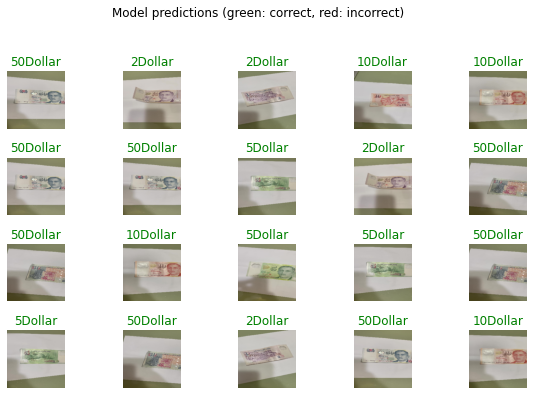

In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")  

In [ ]:
from keras.preprocessing import image

In [ ]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
!cp -r "/content/my_model" "/content/drive/MyDrive/IoT"